# Algorisme genètic canònic.

En aquesta pràctica implementarem l'algorisme genètic canònic per tal de solucionar el mateix problema que a la pràctica 2: trobar els coeficients d'una recta per tal de trobar la recta que millor ajusta una sèrie de punts observats. 

Després de generar les dades, definirem una sèrie de funcions que serviran per implementar parts de l'algorisme. Això ens permetrà comprovar que aquestes diferents parts funcionen correctament. Amb petites modificacions posteriors, finalment les unificarem en la  implementació de l'algorisme complet.

In [263]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from IPython import display

**P1.** Igual que a la pràctica 2, creeu les observacions a partir d'una recta amb una mica de soroll:

Recordeu l'equació de la recta $y=a x + b$. 

1. Definiu els coeficients inicials ($a_0$, $b_0$) escollint valors dins de l'interval [-5,5] ($a_0 \in [-5,5]$, $b_0 \in [-5,5]$).
2. Genereu 10 punts distribuïts equidistantment entre 1 i 10 i guardeu-los a la variable $x$. A cada punt assigneu el valor que defineix la recta. 
3. Afegiu soroll gaussià a cada punt (mitja 0, desviació estàndard 1). Aquestes seran les vostres observacions ($y_{obs}$ en la fórmula del MSE a sota) 
4. Visualitzeu les observacions juntament amb la recta inicial.

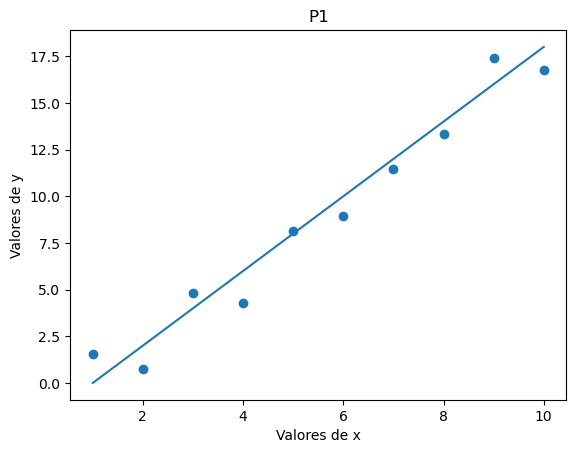

In [264]:
# Escollim coeficients inicials
a0 = 2
b0 = -2

# Vector x de 10 punts
x = np.arange(1,11)

# Equació de la recta
y = a0*x + b0

# Recta amb soroll
soroll = np.random.normal(0,1,10)
yobs = y + soroll

# Gràfiquem 
plt.plot(x,y)
plt.scatter(x,yobs) # Punts de la recta amb soroll
plt.xlabel('Valores de x') 
plt.ylabel('Valores de y')
plt.title('P1') # Títol
plt.show()

**P2.** Recupereu la classe individual2 de la pràctica 3 i poseu-li per nom "individual". 

**P2.1** Modifiqueu la classe individual per tal d'afegir-hi l'atribut fitness. Modifiqueu la funció d'inicialització per tal que la fitness també pugui ser especificada al crear una instància i, si no, prengui el valor 0.

**P2.2.** Definiu la funció *assign_fitness*, que agafi com a argument un individu de la classe individual i assigni la fitness corresponent (1/MSE) a l'atribut *fitness*. 

Recordeu la fórmula del MSE:

$E=\frac{1}{n}\Sigma_{i=0}^{n-1}(y_{i,obs}-y_{i,pred})^2$


**P2.3.** Comproveu que tot funciona com espereu. 

In [265]:
# Creem una classe anomenada individual

class individual():
    def __init__(self, n=1, g=None, boundslow=None, boundshigh=None, f=0): # Definim els atributs corresponents
        self.n = n
        self.boundslow = np.array(boundslow) 
        self.boundshigh = np.array(boundshigh)
        self.genotype = np.array(g)
        self.fitness = f
        
        if self.boundslow is None:
            self.boundslow = np.zeros(self.n)
            
        if self.boundshigh is None:
            self.boundshigh= np.ones(self.n)
            
        if self.genotype is None: # Si no es defineix el genotip, li assignem la funció set_random_genotype
            self.genotype = self.set_random_genotype()
        
    def set_random_genotype(self):
        random_gen = [] # Creem llista 
        
        for i in range (self.n):
            w = np.random.uniform (self.boundslow[i],self.boundshigh[i]) #generem nombre aleatori en un rang específic
            random_gen.append(w) # Afegim el número a la llista
        return random_gen 
    
    def assign_fitness (self):
        x = np.arange(1,11)
        y_ind = self.genotype[0]*x + self.genotype[1] #Recta sense soroll
        
        a0 = 2
        b0 = -2
        y = a0*x + b0
        diferencia = y_ind - y
        suma = sum((diferencia)**2)
        n = len(x)
        E = (1/n)*suma
        self.fitness = 1/E
       

**P3**. Mutació. 

3.1 A continuació, definiu una funció de mutació *mutate* que apliqui una mutació gaussiana: per cada gen del genotip d'un individu, amb probabilitat *p_mut* el valor pot ser modificat afegint un nombre aleatori extret d'una distribució normal centrada en 0 i amb desviació estàndard $\sigma$. 

La funció ha de prendre 3 arguments: un individu de la classe individual, i els paràmetres *p_mut* i *sigma*. 

In [267]:
def mutate(ind,p_mut,sigma):
    i = 0
    while i < len(ind.genotype):
        p = np.random.uniform(0,1) # Mean = 0 i desviació standard = 1
        if p <= p_mut:
            num_aleatori = np.random.normal(0,sigma)
            ind.genotype[i] = ind.genotype[i] + num_aleatori # Valor modificat afegint un nombre aleatori
        i = i+1
        
    return ind

**P4.** Selecció. 

P4.1. Implementeu una funció que donat un array de valors de fitness, no necessàriament en ordre, seleccioni una de les fitness segons "fitness-proportionate selection": 

Donades les fitness en ordre creixent $[f_0, f_1, \cdots, f_{n-1}]$, genereu un nombre aleatori $r \in [0, \sum_{j=0}^{n-1}f_{j}$] i escolliu l'index $k$ tal que:

$\sum_{j=0}^{k-1}f_j \le r < \sum_{j=0}^{k}f_j$

Exemple: Imagineu que teniu les fitness [15,10,20, 14]. En aquest cas, el valor cumulatiu de les fitness ordenades: [10, 24, 39, 59]. Imagineu que extraieu el valor r=28.5. La funció hauria de retornar en aquest cas la fitness amb índex 2 (39), ja que 28.5 està entre 24 i 39. 

Podeu primer codificar aquest cas concret, i després afegir que $r$ sigui un nombre aleatori dins del rang corresponent, generalitzar-ho per qualsevol array de fitness i convertir-ho en funció. Comproveu també que si el nombre extret fos 5, retornaria l'individu amb índex 0 en el cas de l'exemple.



In [270]:
def choose_index (listfit): # Definim la funció entrant-li llista de fitness 
    listord = np.sort(listfit) # Ordenem la llista de fitness
    listvaloracum = np.cumsum(listord) # Sumatori de fitness ordenades
    r = np.random.uniform(0,listvaloracum[-1]) # Valor aleatòri que estigui dins la llista
    
    i = 0
    while i < (len(listvaloracum)): 
        if listvaloracum[i] <= r:
            i = i+1
            
        if listvaloracum[i] > r:
            return listvaloracum[i],i
            break
    

P4.2. Implementeu la funció *select* que prengui com a argument la llista d'individus corresponent a la població, i en retorni dos de diferents (seran els pares en la implementació de l'algorisme), segons el procés de *fitness proportionate selection* implementat a dalt.

Modifiqueu lleugerament el que heu implementat a la funció del punt 4.1: obteniu l'array de fitness dels individus, ordeneu les fitness, seleccioneu un individu, creeu un segon array d'individus i de fitness sense el que heu seleccionat ja, torneu a recalcular els ordres i seleccioneu un segon individu.

In [405]:
def select (listpob):
    
    pares = []
    d = listpob[:]
    
    for i in range(2):
        listfit = []
        k = 0
        while k < (len(d)):
            listfit.append(d[k].fitness)
            k = k+1
            
        listfit_ord = np.sort(listfit)
        acumulada = np.cumsum(listfit_ord)
        
        r = np.random.uniform(0,acumulada[-1])

        i = 0
        while i < (len(acumulada)): 
            if acumulada[i] <= r:
                i = i+1
            if acumulada[i] > r:
                f = listfit[i]
                break

        for p in d:
            if p.fitness == f:
                pares.append(p)
                d.remove(p)
                break
        
    return pares

**P5**. Crossover.

Implementeu la funció *mate* que prengui 3 arguments: 2 pares ( $p_1$, $p_2$ ) i $\eta$, i retorni dos fills ($f_1$, $f_2$). Els genotips dels fills es determinen segons el mètode de *simulated binary crossover*:
$$
f_1=(1/2)[(1+\beta)p_1 + (1-\beta)p_2]\\
f_2=(1/2)[(1-\beta)p_1 + (1+\beta)p_2]
$$

on $\beta$ s'escull segons:
$$
\beta=\begin{cases}
(2u)^{\frac{1}{\eta+1}}, & \text{if } u \leq 0.5\\
\frac{1}{2(1-u)}^{\frac{1}{\eta+1}}, &\text{if } u > 0.5 \\
\end{cases}
$$
i $u$ és un nombre aleatori extret entre [0,1] i $\eta$ és el *crowding factor* o *distribution index*.

Per fer els fills, podeu primer fer una còpia dels pares i després aplicar el crossover.

Comproveu que la funció fa el que espereu: creeu dos individus amb dos genotips coneguts, i vegeu quins genotips tenen els fills que retorna la vostra funció *mate*. Comproveu que els genotips dels pares es mantenen intactes.


In [274]:
def mate (p1, p2, nu): 
    u = np.random.uniform(0,1)
    if u <= 0.5: 
        beta = (2*u)**(1/(nu+1)) # Fórmula
        #print(beta)
        
    else:
        beta = (0.5*(1/(1-u)))**(1/(nu+1)) 
        #print(beta)
        
    f1 = 0.5*(((1+beta)*p1)+(p2*(1-beta)))
    f2 = 0.5*(((1-beta)*p1)+(p2*(1+beta)))

    
    return f1,f2

**P6**. Algorisme genètic.

Finalment, definiu una funció que executi l'algorisme genètic canònic fent servir la classe individual per definir els individus i les funcions *assign_fitness*, *select*, *mate*, *mutate*.

La funció ha de prendre com a arguments amb paraules clau tots els arguments que necessiten les vostres funcions, més el que sigui necessari per especificar la població d'individus i el bon funcionament de l'algorisme.

Feu que el millor individu de cada generació sempre passi a la següent. 

Feu que la probabilitat de crossover entre dos pares sigui p_crossover, i que la mutació de cada fill després del crossover s'executi només amb probabilitiat p_mut_ind.

Feu que al final de l'execució pugueu fer un gràfic de la fitness mitjana i màxima a cada iteració.

Executeu l'algorisme per diferents seeds. Feu gràfics dels resultats obtinguts (la recta que correspon a la $a$ i $b$ trobada juntament amb les observacions)  i comenteu-los breument.


In [407]:
def algorisme_genetic_canonic (pob,a_nu,p_crossover,p_mut_ind, a_p_mut,a_sigma):
    nova_generacio = []

    for j in range (len(pob)):
        pares = select(pob) # em retorna 2 ind
        pares_gen =[]
        pare1_gen = pares[0].genotype
        pare2_gen = pares[1].genotype
        pares_gen.append(pare1_gen)
        pares_gen.append(pare2_gen)


        prob1 = np.random.uniform(0,1) # numero aleatori per a p_crossover
        if prob1 <= p_crossover:
            fills = mate(p1=pare1_gen,p2=pare2_gen,nu=a_nu) # agafa genotips i torna genotips 
        else:
            fills = pares_gen[:]

        
        #mutacio
        prob2 = np.random.uniform(0,1) 
        if prob2 <= p_mut_ind:
            fill_1 = individual(g=fills[0])
            fill_1_mutat = mutate(ind=fill_1,p_mut=a_p_mut,sigma = a_sigma) 
            nova_generacio.append(fill_1_mutat)
        else:
            fill_1 = individual(g=fills[0])
            nova_generacio.append(fill_1)
            

        prob3 = np.random.uniform(0,1)
        if prob3 <= p_mut_ind:
            fill_2 = individual (g=fills[1])
            fill_2_mutat = mutate(ind=fill_2,p_mut=a_p_mut,sigma = a_sigma)
            nova_generacio.append(fill_2_mutat)
        else:
            fill_2 = individual (g=fills[1])
            nova_generacio.append(fill_2)
            
        if len(nova_generacio) == len(pob):
            break
            
    
    
    #llista de fitness d'individus de la nova generació
    nova_generacio_fitness = []
    for h in range (len(nova_generacio)):
        nova_generacio_fitness.append(nova_generacio[h].fitness)
    nova_generacio_fitness_ord = np.sort(nova_generacio_fitness)
    fmenor = nova_generacio_fitness_ord[0]
    
    for g in range(len(nova_generacio)):
        if nova_generacio[g].fitness == fmenor:
            nova_generacio.remove(nova_generacio[g])
            break
    
    
    
    #substituyo mejor fitness de los padres por la peor de los hijos
    pob_fitness = []
    for h in range (len(pob)):
        pob_fitness.append(pob[h].fitness)
    pob_fitness_ord = np.sort(pob_fitness)
    fmayor = pob_fitness_ord[-1]
    
    for g in range(len(pob)):
        if pob[g].fitness == fmayor:
            nova_generacio.append(pob[g])
            break
    
    return nova_generacio

C:\Users\elena\AppData\Local\Temp\ipykernel_22292\349232752.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  self.fitness = 1/E


a trobada:0.453872116647549
b trobada:5.0


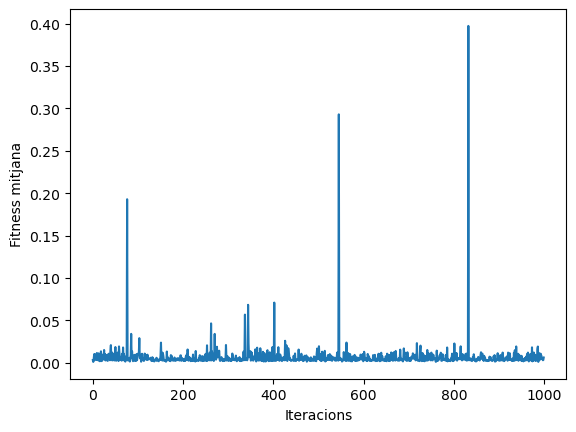

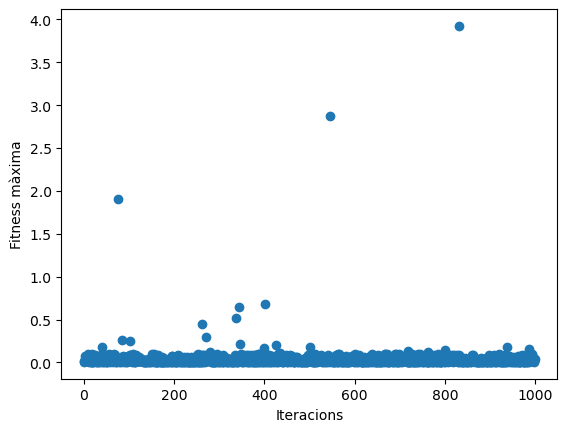

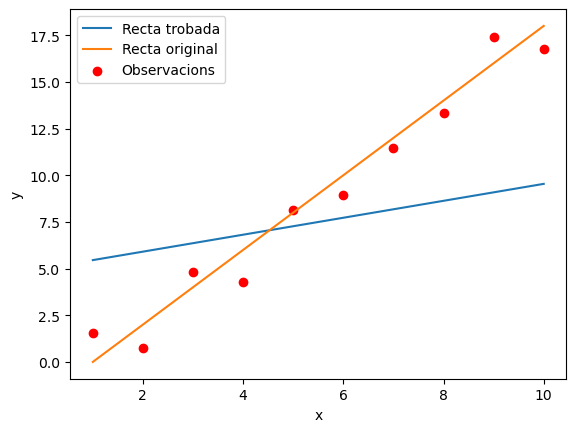

In [425]:
poblacio2 = [] # Creem llista de població
for i in range (10):
    ind = individual (g = [3,5]) # Assignem genotip als individus
    ind.assign_fitness()
    mutate(ind, p_mut = 0.5, sigma = 15) # Mutem el genotip
    poblacio2.append(ind) # Afegim els individus a la llista de poblacio
    

iteracions = np.arange(1000)
mean_fitness = []
max_fitness = []
for l in range (len(iteracions)):
    x = algorisme_genetic_canonic (pob = poblacio2, a_nu = 4,p_crossover=0.9,p_mut_ind=0.2, a_p_mut=0.9,a_sigma=6)
    vector = []
    for k in range (len(x)):
        x[k].assign_fitness()
        f = x[k].fitness
        vector.append(f)
    vector_ord = np.sort(vector)
    max_fitness.append(vector_ord[-1])
    mean_fitness.append(np.mean(vector))
    
vectorfinal_ord = np.sort(vector)
fmax = vectorfinal_ord[len(vectorfinal_ord)-1]


for m in range (len(x)):
    if x[m].fitness == fmax:
        a = x[m].genotype[0]
        b = x[m].genotype[1]
        break


        
print(f'a trobada:{a}')
print(f'b trobada:{b}')

plt.plot(iteracions,mean_fitness)
plt.xlabel('Iteracions')
plt.ylabel('Fitness mitjana')
plt.show()

plt.scatter(iteracions,max_fitness)
plt.xlabel('Iteracions')
plt.ylabel('Fitness màxima')
plt.show()



x = np.arange(1,11)
a0 = 2
b0 = -2
y0 = a0*x + b0 #Recta original
y = a*x + b # Recta amb a i b obtingudes
plt.plot(x,y,label='Recta trobada')
plt.plot(x,y0,label='Recta original')
plt.scatter(x,yobs,label='Observacions',color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


In [ ]:
# La a i b hem suposat que corresponien al genotip de la millor fitness de l'última generació però varien molt a cada iteració i no ens han acabat de sortir les a i b que hem utilitzat al primer exercici. 
# Per molt que hem buscat l'error no l'hem trobat. Tot i així, hem entès que el genetic algorithm serveix com a tècnica de recerca i optimització inspirada en els principis de la selecció natural.
# A més, suposem que la Fitness mitjana hauria d'augmentar a cada generació i això no es mostra en el nostre gràfic.